In [1]:
from utils import *
from preprocessing import *
SIZE = 256

/home/jingxi/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)


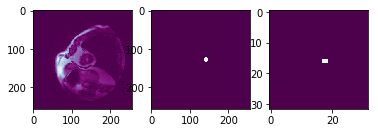

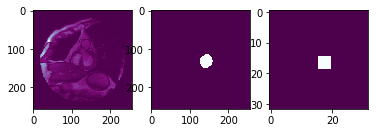

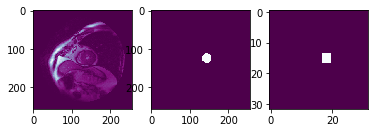

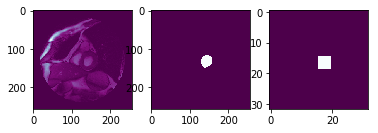

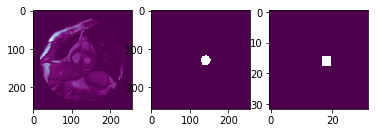

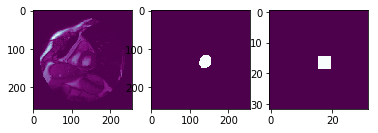

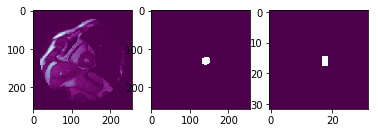

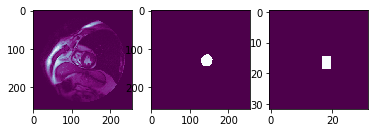

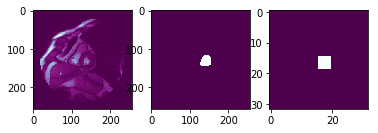

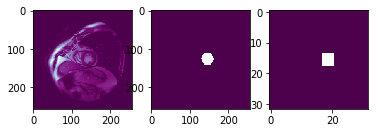

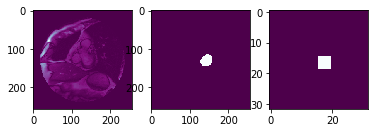

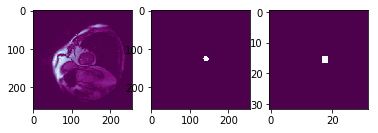

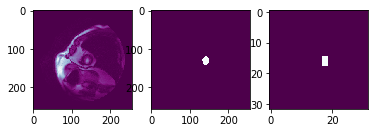

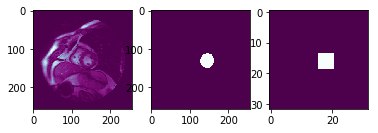

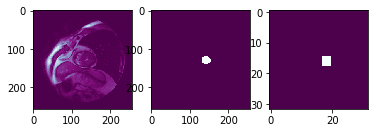

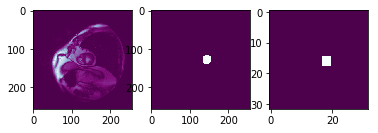

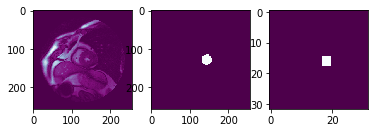

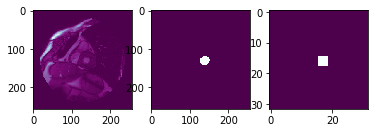

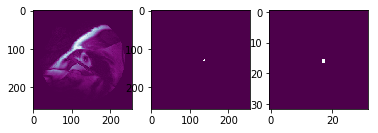

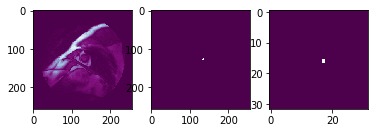

(526, 64, 64, 1)
(526, 1, 32, 32)


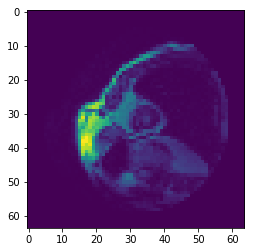

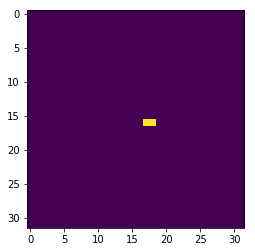

Size for each layer :
Layer, Input Size, Output Size
('Conv2D_1', (None, 64, 64, 1), (None, 54, 54, 100))
('Average_Pooling2D_1', (None, 54, 54, 100), (None, 9, 9, 100))
('Reshape_1', (None, 9, 9, 100), (None, 1, 8100))
('Dense_1', (None, 1, 8100), (None, 1, 1024))
('Reshape_2', (None, 1, 1024), (None, 1, 32, 32))
Epoch 1/10
526/526 [==============================] - 2s 3ms/step - loss: 0.1879 - acc: 0.3094
Epoch 2/10
526/526 [==============================] - 0s 878us/step - loss: 0.1060 - acc: 0.2689
Epoch 3/10
526/526 [==============================] - 0s 791us/step - loss: 0.0747 - acc: 0.0998
Epoch 4/10
526/526 [==============================] - 0s 813us/step - loss: 0.0566 - acc: 0.0381
Epoch 5/10
526/526 [==============================] - 0s 827us/step - loss: 0.0456 - acc: 0.0400
Epoch 6/10
526/526 [==============================] - 0s 785us/step - loss: 0.0383 - acc: 0.0454
Epoch 7/10
526/526 [==============================] - 0s 785us/step - loss: 0.0330 - acc: 0.0494
Epoch 8

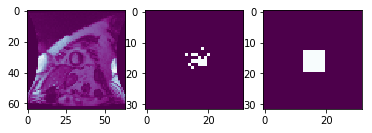

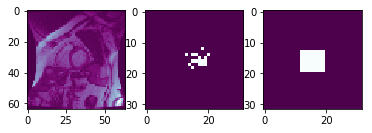

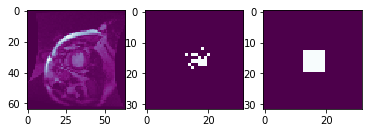

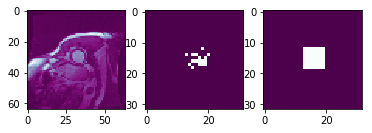

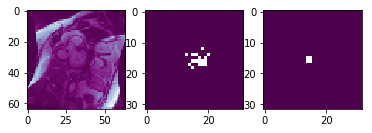

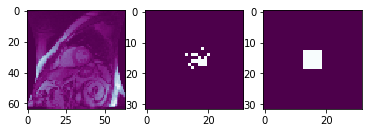

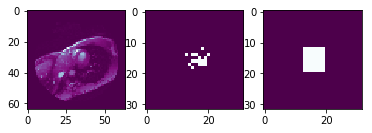

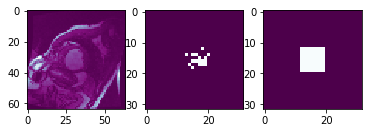

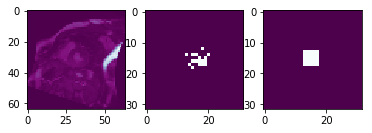

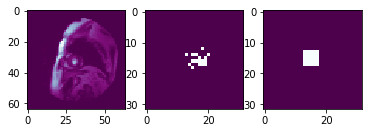

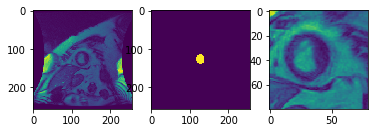

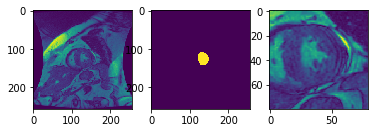

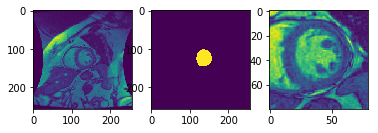

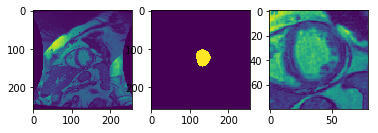

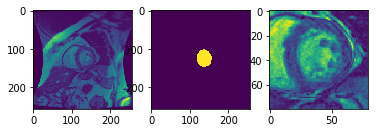

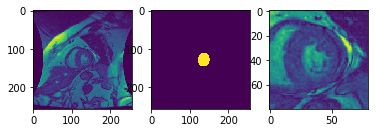

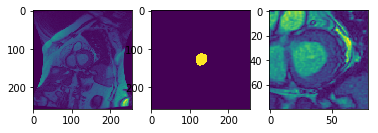

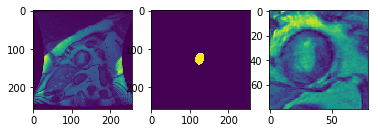

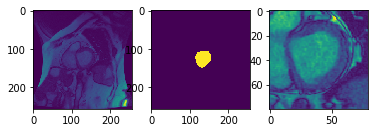

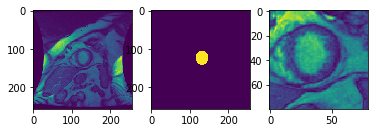

Normalized confusion matrix
[[0.91975029 0.08024971]
 [0.00397935 0.99602065]]


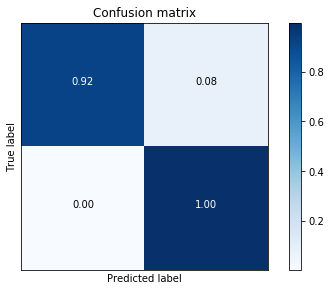

Stored 'y_pred' (ndarray)
(279, 1, 32, 32)


In [2]:
%run 'demo.ipynb'
%store y_pred
print (y_pred.shape)

In [3]:
cropped = get_cropped(img_test, y_pred, win_size = 80)

In [4]:
print (cropped.shape)

(279, 80, 80, 1)


In [5]:
def get_mask_roi_pred(img, y_pred, roi_size = 32):
    n = img.shape[0]
    mask_roi = np.zeros((n, 256, 256, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   
    return mask_roi

In [6]:
mask_roi =get_mask_roi_pred(img_test,y_pred)
print(mask_roi.shape)

(279, 256, 256, 1)


In [7]:
def get_mask_pred(img,y_pred):
    n = img.shape[0]
    mask_contour = np.zeros((n, 80, 80, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_contour[i] =  img[i][x_min:x_max, y_min:y_max]   
    return mask_contour

In [8]:
mask_contour =get_mask_pred(mask_test,y_pred)
print(mask_contour.shape)

(279, 80, 80, 1)


In [9]:
def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(cropped[j],(64 , 64))
        contour = cv2.resize(mask_contour[j], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

In [10]:
X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape

((279, 4096), (279, 4096))

In [11]:
from StackedAeModel import SAE

/home/jingxi/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [12]:
h, model = SAE(X_train,Y_train)

Text(0.5,0,'epochs')

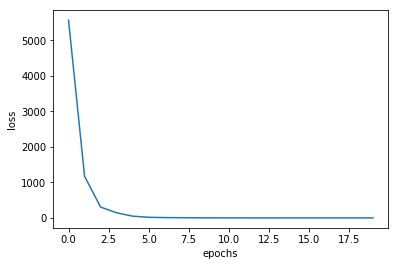

In [13]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')

In [14]:
def prediction_plot(X, model, idx=None):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    if not idx:
        idx= np.random.randint(len(X))
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64), idx

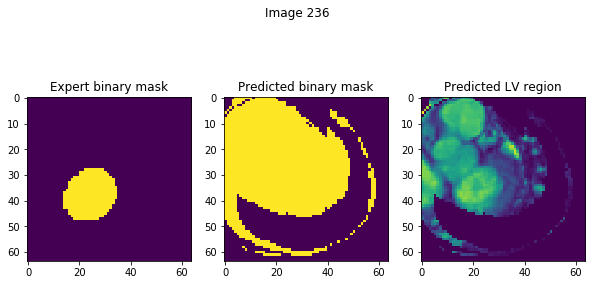

In [17]:
f, ax = plt.subplots(ncols=3, figsize=(10,5))
bin_mask, img, idx = prediction_plot(X_train, model)
ax[0].imshow(Y_train[idx].reshape((64,64)))
ax[0].set_title('Expert binary mask')
ax[1].imshow(bin_mask)
ax[1].set_title('Predicted binary mask')
ax[2].imshow(img)
ax[2].set_title('Predicted LV region')
_ = plt.suptitle('Image %s' % idx)